# Downstream analysis of scRNAseq data from the developing mouse habenula (DevHb)

The data was retrived as fastq files, trimmed and mapped using STARMAP. Spliced, unspliced and total RNA files (coutc, coutb and coutt) are merged, renamed and cleaned up on HPC (High Performance Cluster).

The dataset has a total of 2 plates per 8 different timepoint, except for timepoint 12 this only consists of one plate. 

The data has been merged and filtered in Scanpy. The raw count matrix was loaded into Seurat. There the data was normalized and scaled. The IntegrateData() function of Seurat was used to remove the batch effect between the timepoints. adata.X is replaced with the corrected count matrix from Seurat. In this way all other metadata like spliced/unspliced transcripts stay in place.


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.sparse import csr_matrix

#settings
sc.settings.verbosity = 3
sc.logging.print_versions()
scv.logging.print_versions()
sc.settings.figdir = "../../figures/embryo_Hb/Seurat"
scv.settings.figdir = "../../figures/embryo_Hb/Seurat"
sc.settings.set_figure_params(dpi=80)

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.6 anndata==0.7.4 umap==0.3.10 numpy==1.19.2 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1
scvelo==0.1.25  scanpy==1.4.6  anndata==0.7.4  loompy==3.0.6  numpy==1.19.2  scipy==1.4.1  matplotlib==3.3.2  sklearn==0.22.1  pandas==1.0.1  

For better visualization of some plots, different colorschemes for continuous data are made.

In [2]:
c_cont_red = mpl.colors.LinearSegmentedColormap.from_list('custom_red', 
                                             [(0, 'silver'),
                                              (0.1, (1, 0.82, 0.82)),
                                              (0.2, (1, 0.67, 0.67)),
                                              (0.3, (1, 0.58, 0.58)),
                                              (0.4, (1, 0.48, 0.48)),
                                              (0.5, (1, 0.38, 0.38)),
                                              (0.6, (1, 0.29, 0.29)),
                                              (0.7, (1, 0.22, 0.22)),
                                              (0.8, (1, 0.15, 0.15)),
                                              (0.9, (0.67, 0.09, 0.09)),
                                              (1, (0.54, 0, 0))], N=128)
c_cont_green = mpl.colors.LinearSegmentedColormap.from_list('custom_green', 
                                             [(0, 'silver'),
                                              (0.1, (0.50, 0.93, 0.60)),
                                              (0.2, (0.4, 0.89, 0.5)),
                                              (0.3, (0.3, 0.81, 0.4)),
                                              (0.4, (0.2, 0.73, 0.3)),
                                              (0.5, (0.1, 0.69, 0.2)),
                                              (0.6, (0, 0.62, 0.185)),
                                              (0.7, (0, 0.55, 0.16)),
                                              (0.8, (0, 0.47, 0.15)),
                                              (0.9, (0, 0.36, 0.11)),
                                              (1, (0, 0.29, 0.06))], N=128)
c_cont_blue = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', 
                                             [(0, 'silver'),
                                              (0.1, (0.67, 0.77, 1)),
                                              (0.2, (0.58, 0.68, 1)),
                                              (0.3, (0.48, 0.58, 1)),
                                              (0.4, (0.38, 0.48, 1)),
                                              (0.5, (0.29, 0.39, 1)),
                                              (0.6, (0.22, 0.32, 1)),
                                              (0.7, (0.15, 0.25, 1)),
                                              (0.8, (0.09, 0.19, 1)),
                                              (0.9, (0, 0.1, 0.75)),
                                              (1, (0, 0.1, 0.5))], N=128)

## Import data from Seurat after IntegrateData() batch effect removal

In [3]:
adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_filtered_Pou4f1_only.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 2773 × 30452
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [5]:
sc.pp.normalize_total(adata, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:00)


In [6]:
sc.pp.log1p(adata)
## raw data for plotting
adata.raw = adata

In [7]:
counts_cor = pd.read_csv("../../data/input/Seurat_inputAdataX.txt").T

In [8]:
adata.X = counts_cor

## Principle component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

If you want to run this again with the original data, use the following code where we load adata as the normalized dataset.

In [9]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:19)


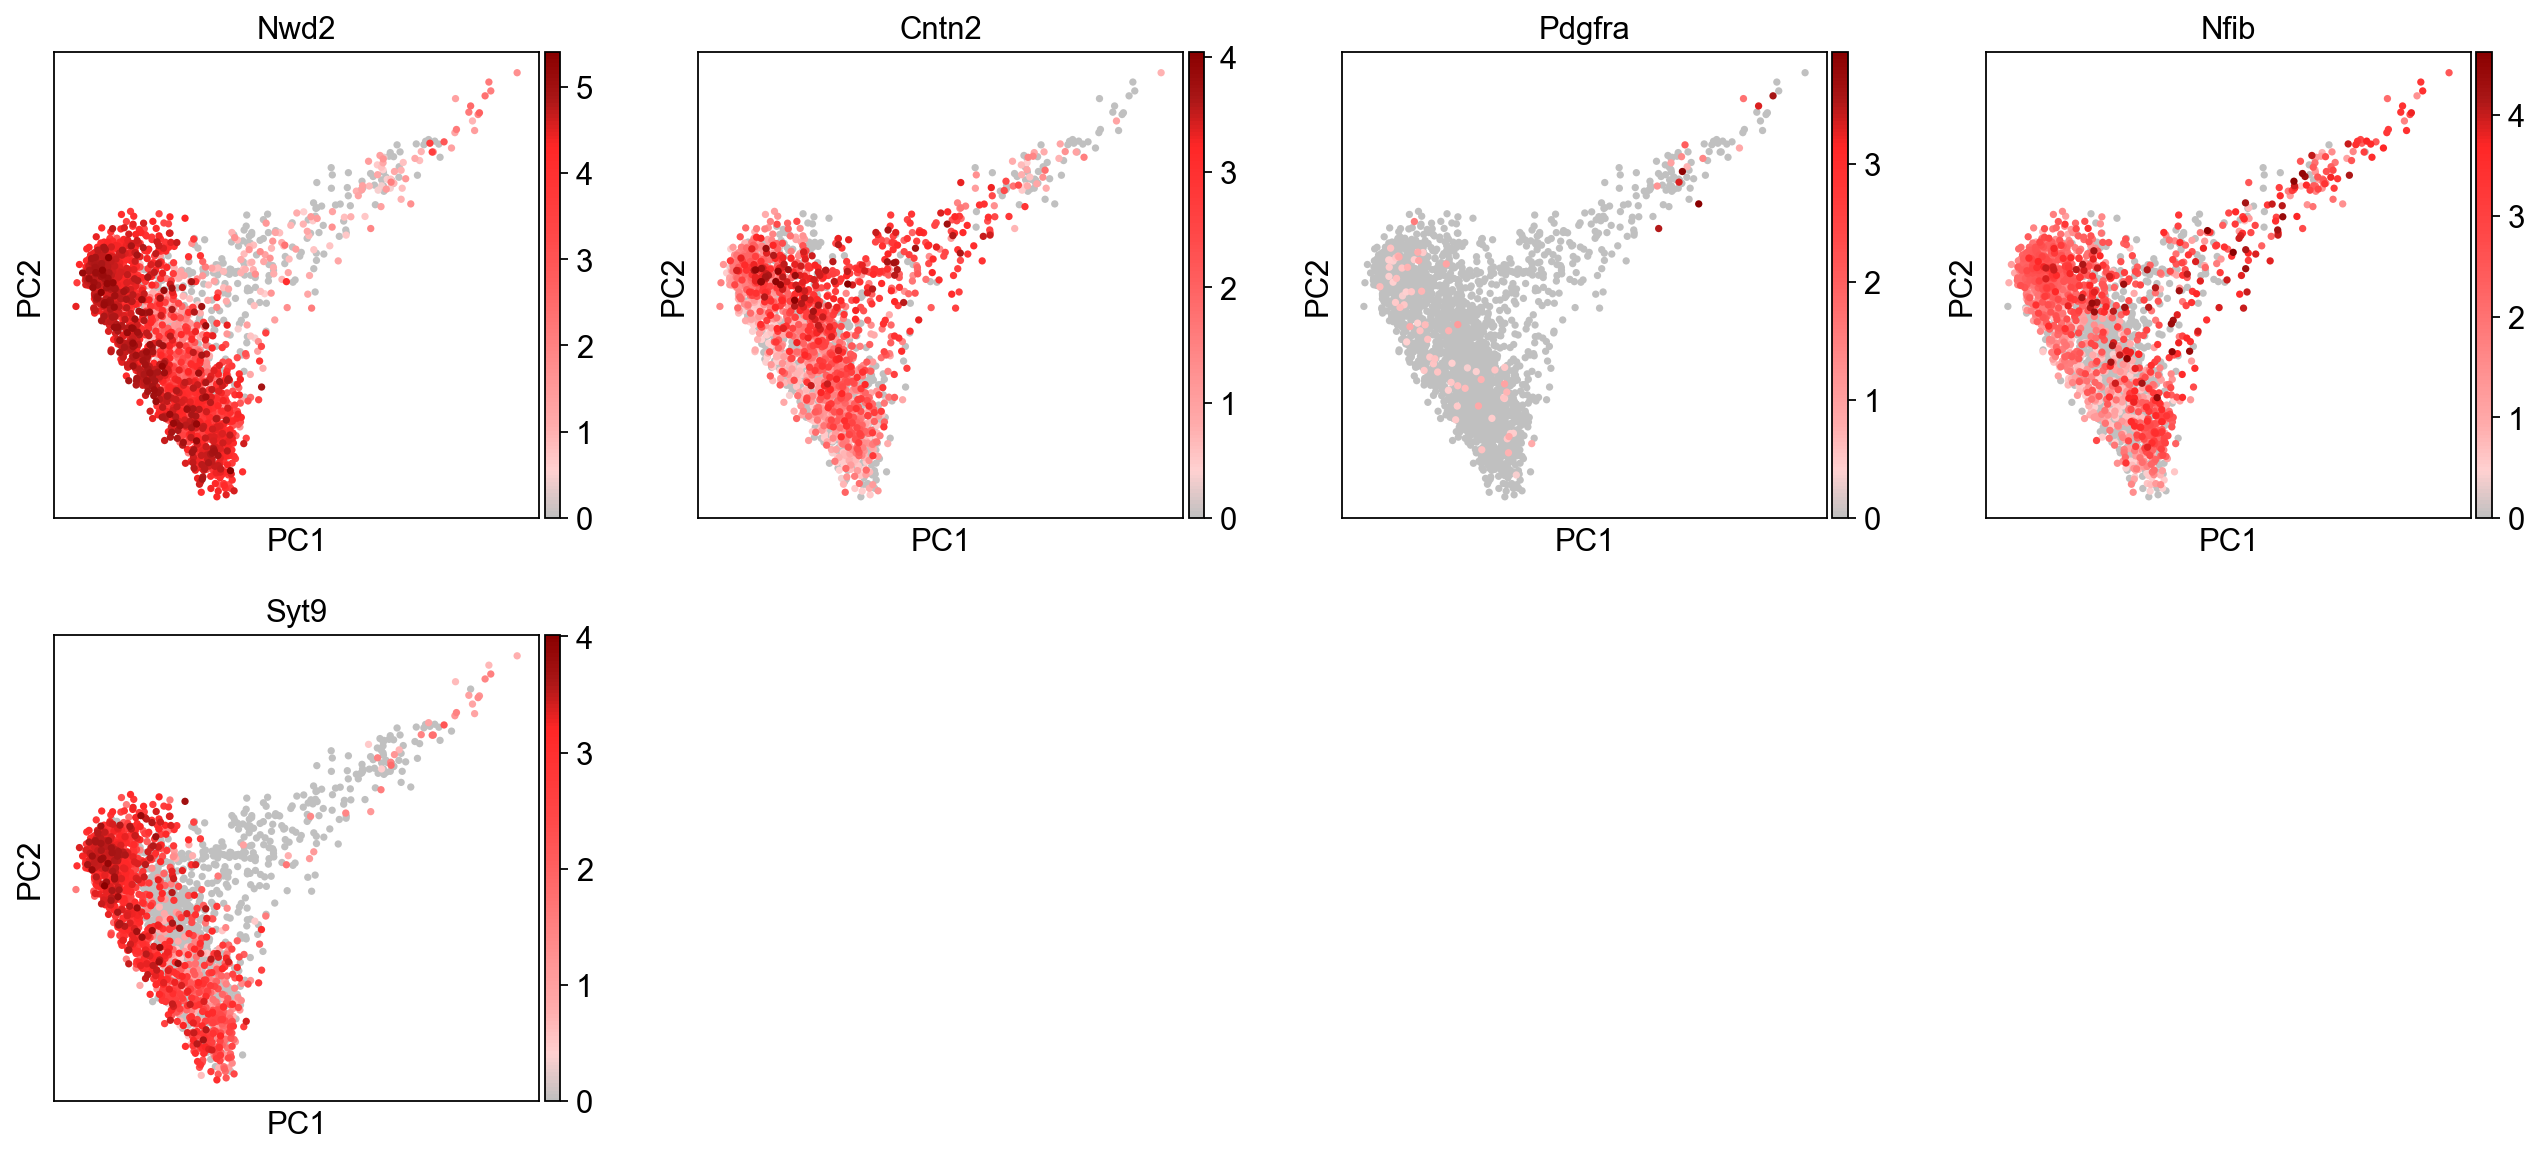

In [10]:
sc.pl.pca(adata, color=["Nwd2", 'Cntn2', 'Pdgfra', 'Nfib', 'Syt9'], cmap=c_cont_red, save = "_bio.pdf")

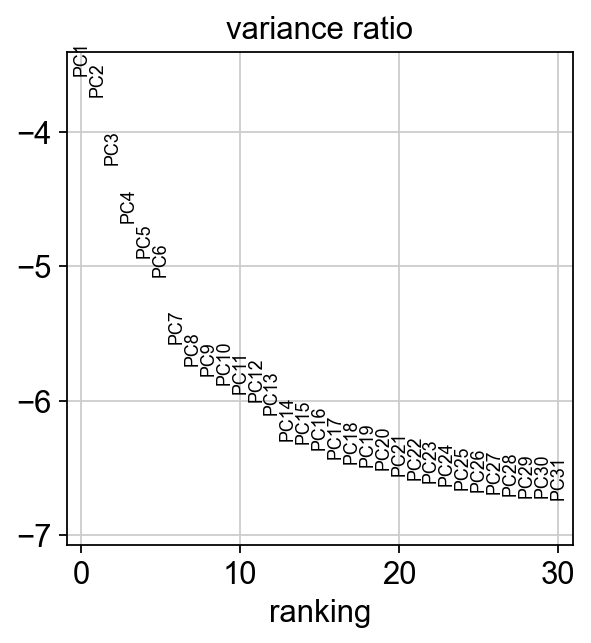

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


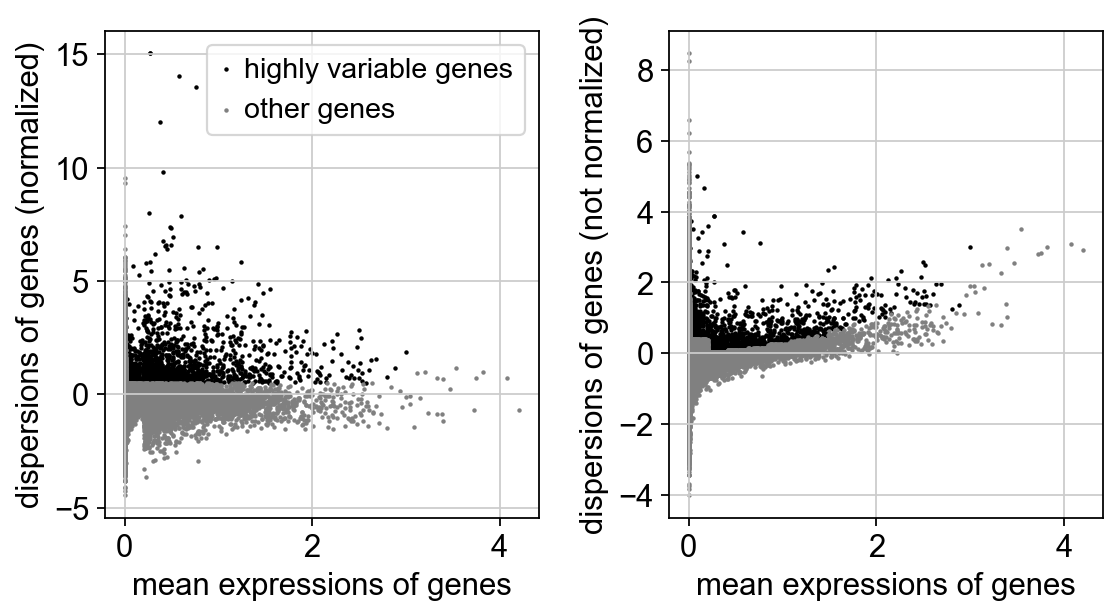

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [13]:
adata = adata[:, adata.var['highly_variable']]

In [14]:
sc.pp.scale(adata, max_value=10)

In [15]:
adata

AnnData object with n_obs × n_vars = 2773 × 2292 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'plate_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

Saving the data with the PC's embedded.

In [16]:
#adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_PCA_seurat.h5ad')

## Computing and embedding the neighborhood graph of cells
In order to compute it, we use the PCA representation of the data matrix.

If you want to run this again with the original data, use the following code where we load adata as the normalized dataset with the PCA representation embedded.

In [38]:
#adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_PCA_seurat.h5ad')

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
## only run this once, if you want to run it again, first load the normalized data with PCA rep.

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


### Embedding using tSNE

In [40]:
sc.tl.tsne(adata)
## only run this once, if you want to run it again, first load the normalized adata with PCA rep.

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:19)


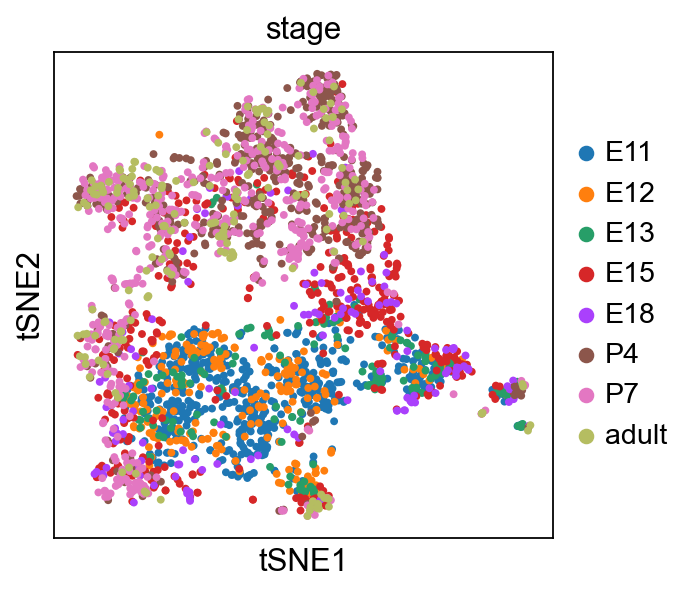

In [43]:
sc.pl.tsne(adata, color= ('stage'), cmap=c_cont_red, s=50) 

Saving the data with the computed neighborhoods.

In [21]:
#adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_neighbors_seurat.h5ad')

## Clustering of the neighborhoodgraph
Clustering with louvain. Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section. 

If you want to run this again with the original data, use the following code where we load adata with the neighborhood graph of cells.

In [22]:
#adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_neighbors_seurat.h5ad')

In [23]:
sc.tl.louvain(adata)
## only run this once, if you want to run it again, first load the data with the neighborhood graph of cells.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


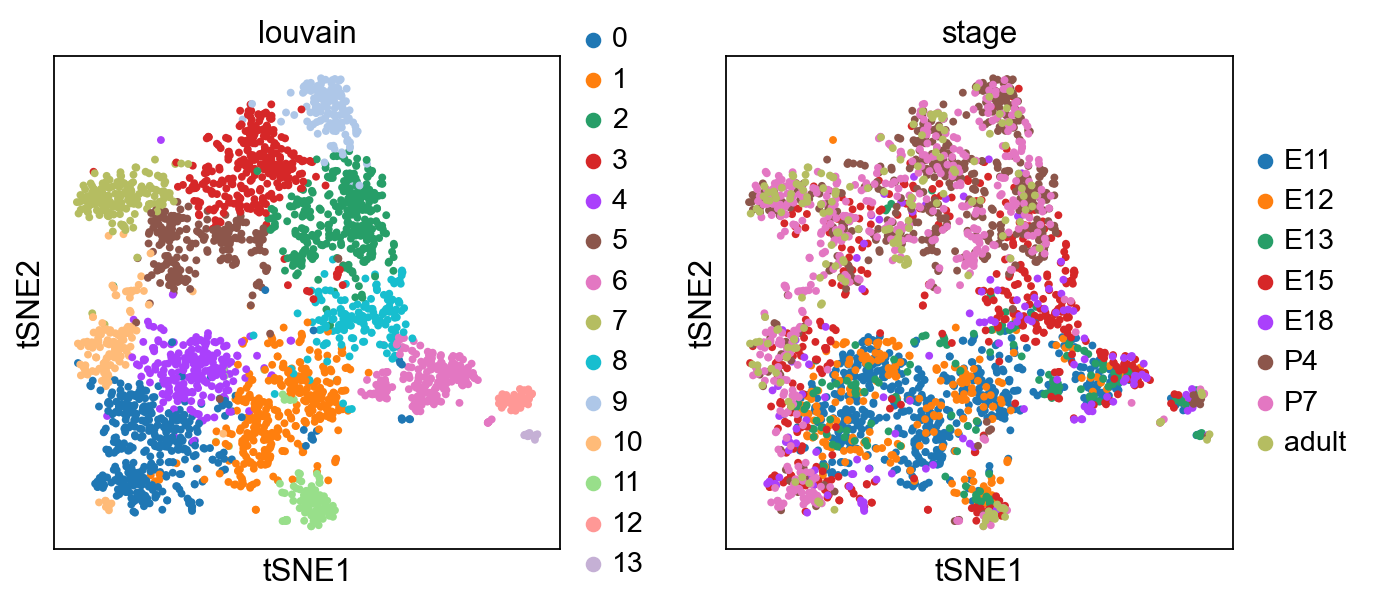

In [44]:
sc.pl.tsne(adata, color= ['louvain', 'stage'], s=50)

Saving the data.

In [25]:
#adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_louvain_seurat.h5ad')

## Finding marker genes
Here we determine the marker genes for each cluster. Together, these genes form the expression pattern of the clusters. In order to do this, we use the Wilcoxon rank-sum test.

If you want to run this again with the original data, use the following code where we load adata with the RNA velocity.

In [26]:
#adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_louvain_seurat.h5ad')

In [27]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


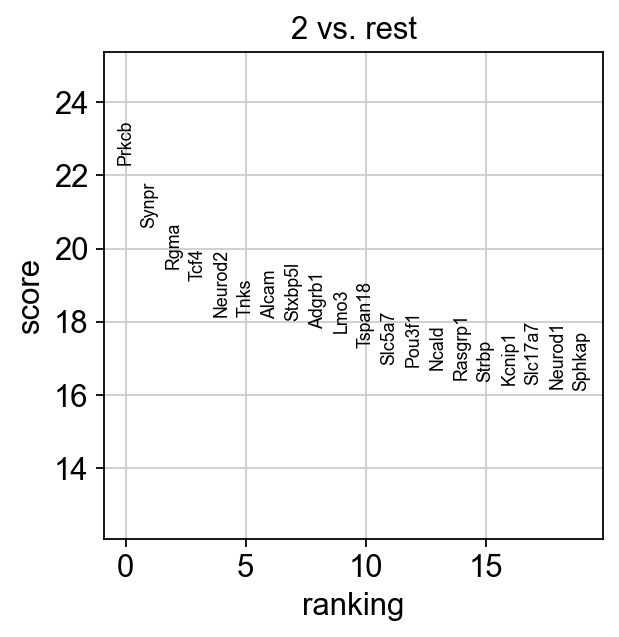

In [28]:
sc.pl.rank_genes_groups(adata, groups=['2'], n_genes=20)

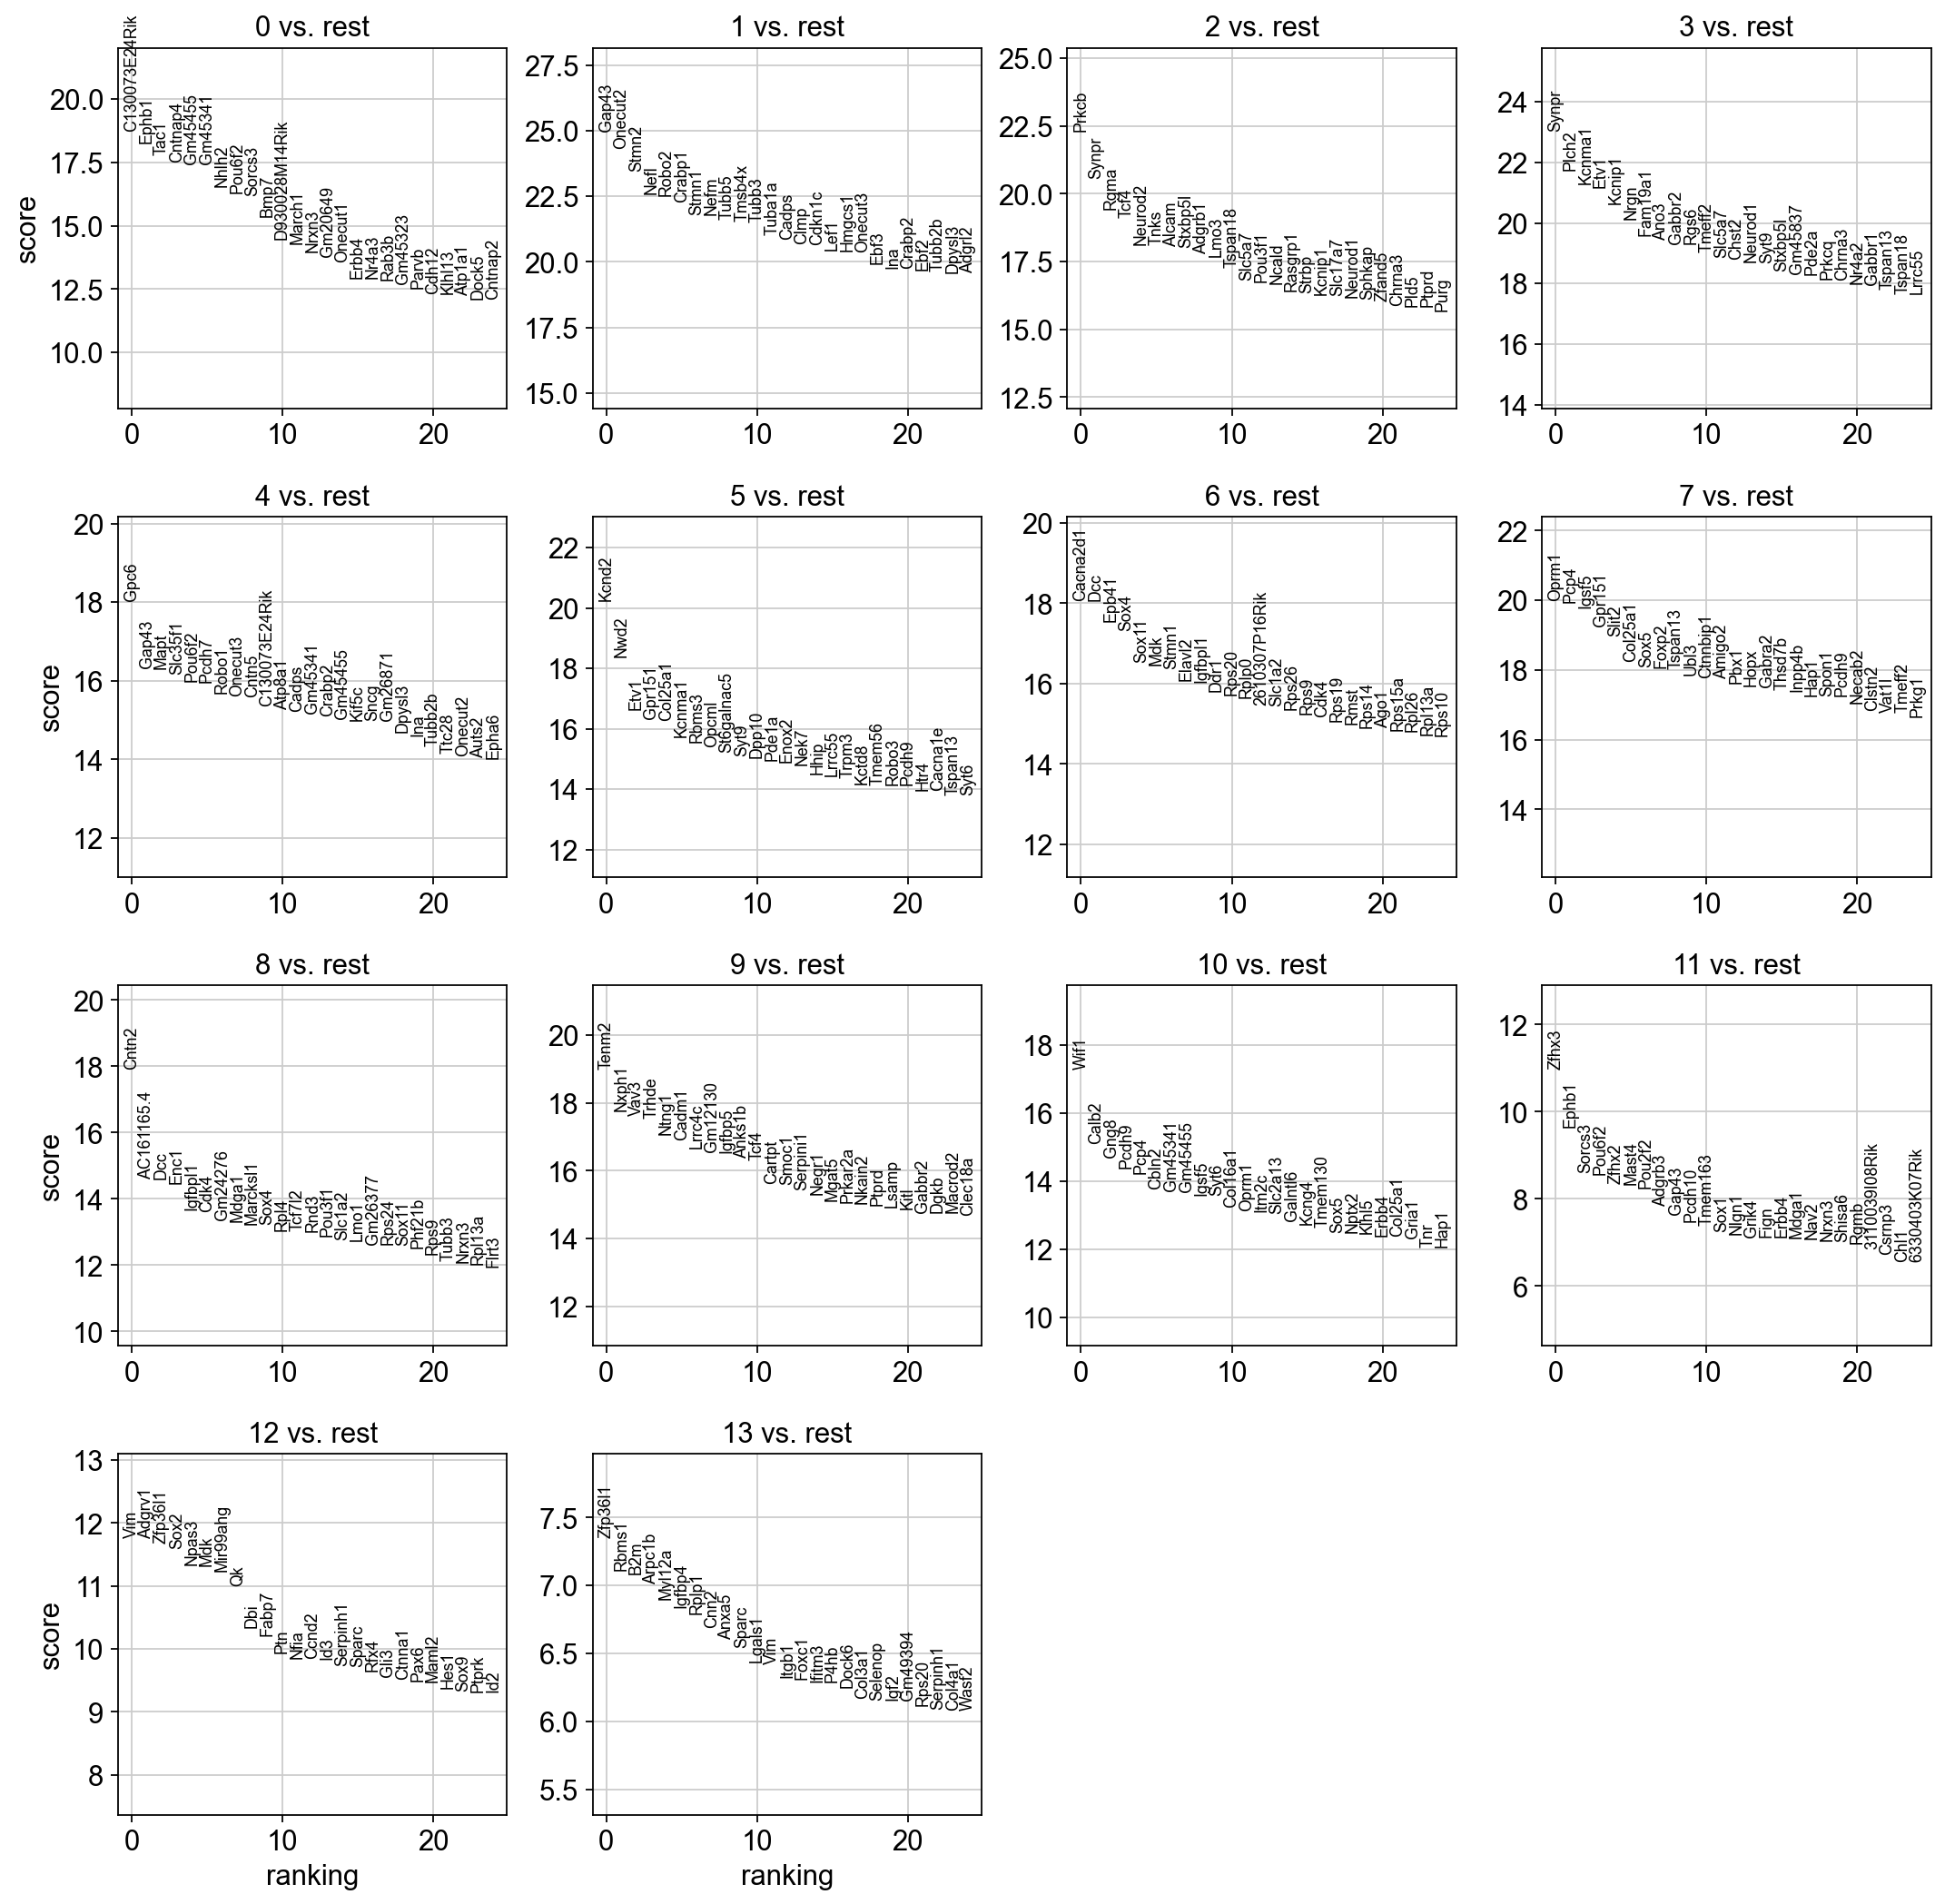

In [29]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the 100 highest ranking marker genes to files: one with just the genes, the other one with the p-value as well.

In [30]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).to_csv(
    '../../data/output/embryo_Hb/Mar2020_embryo_Hb_marker_genes_seurat.csv')

In [31]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p      1_n            1_p      2_n  \
0  C130073E24Rik  2.915016e-78    Gap43  1.144581e-137    Prkcb   
1          Ephb1  1.315008e-74  Onecut2  1.285546e-130    Synpr   
2           Tac1  5.574499e-71    Stmn2  9.220426e-122     Rgma   
3        Cntnap4  9.938869e-69     Nefl  4.504265e-113     Tcf4   
4        Gm45455  3.188971e-68    Robo2  2.193380e-112  Neurod2   

             2_p     3_n            3_p      4_n           4_p  ...    9_n  \
0  3.696002e-110   Synpr  2.575727e-117     Gpc6  7.121644e-73  ...  Tenm2   
1   5.877150e-94   Plch2  6.860540e-105    Gap43  6.196681e-60  ...  Nxph1   
2   2.855946e-84  Kcnma1  1.312631e-100     Mapt  6.578461e-60  ...   Vav3   
3   1.396350e-81    Etv1   1.769931e-99  Slc35f1  7.889101e-59  ...  Trhde   
4   1.663569e-73  Kcnip1   1.165015e-94   Pou6f2  1.478637e-57  ...  Ntng1   

            9_p   10_n          10_p    11_n          11_p     12_n  \
0  1.305647e-80   Wif1  4.603059e-67   Zfhx3  4.405519e-28      Vim   
1  9.853577e-71  Calb2  1.569603e-51   Ephb1  4.800422e-22   Adgrv1   
2  1.452283e-69   Gng8  7.153517e-49  Sorcs3  7.756802e-18  Zfp36l1   
3  5.069653e-69  Pcdh9  6.034848e-47  Pou6f2  1.145074e-17     Sox2   
4  2.464161e-65   Pcp4  5.248901e-46   Zfhx2  6.901765e-17    Npas3   

           12_p     13_n          13_p  
0  5.523800e-32  Zfp36l1  1.926637e-13  
1  6.474595e-32    Rbms1  1.132039e-12  
2  1.599748e-31      B2m  1.405431e-12  
3  4.435853e-31   Arpc1b  2.293393e-12  
4  8.099983e-30   Myl12a  5.155674e-12  

[5 rows x 28 columns]

In [32]:
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv(
     '../../data/output/embryo_Hb/Mar2020_embryo_Hb_marker_genes_pvals_seurat.csv')

In [33]:
#adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_DEgenes_seurat.h5ad')

### For mouse Hb merge: Plot progenitor markers

In [3]:
adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_Pou4f1_louvain_seurat.h5ad')

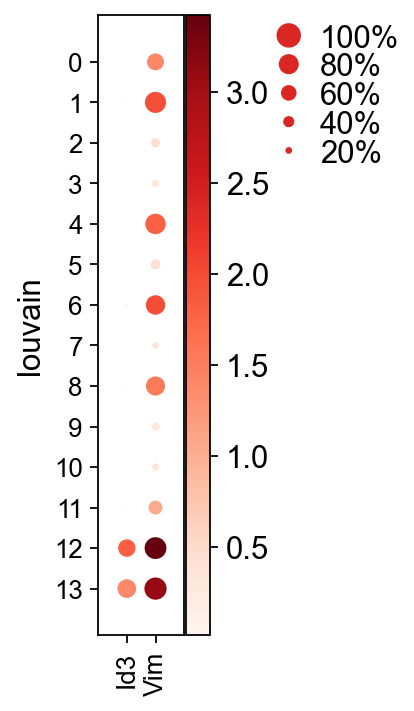

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [36]:
sc.pl.dotplot(adata, ["Id3", "Vim"], groupby="louvain", save="_markersPC.pdf")

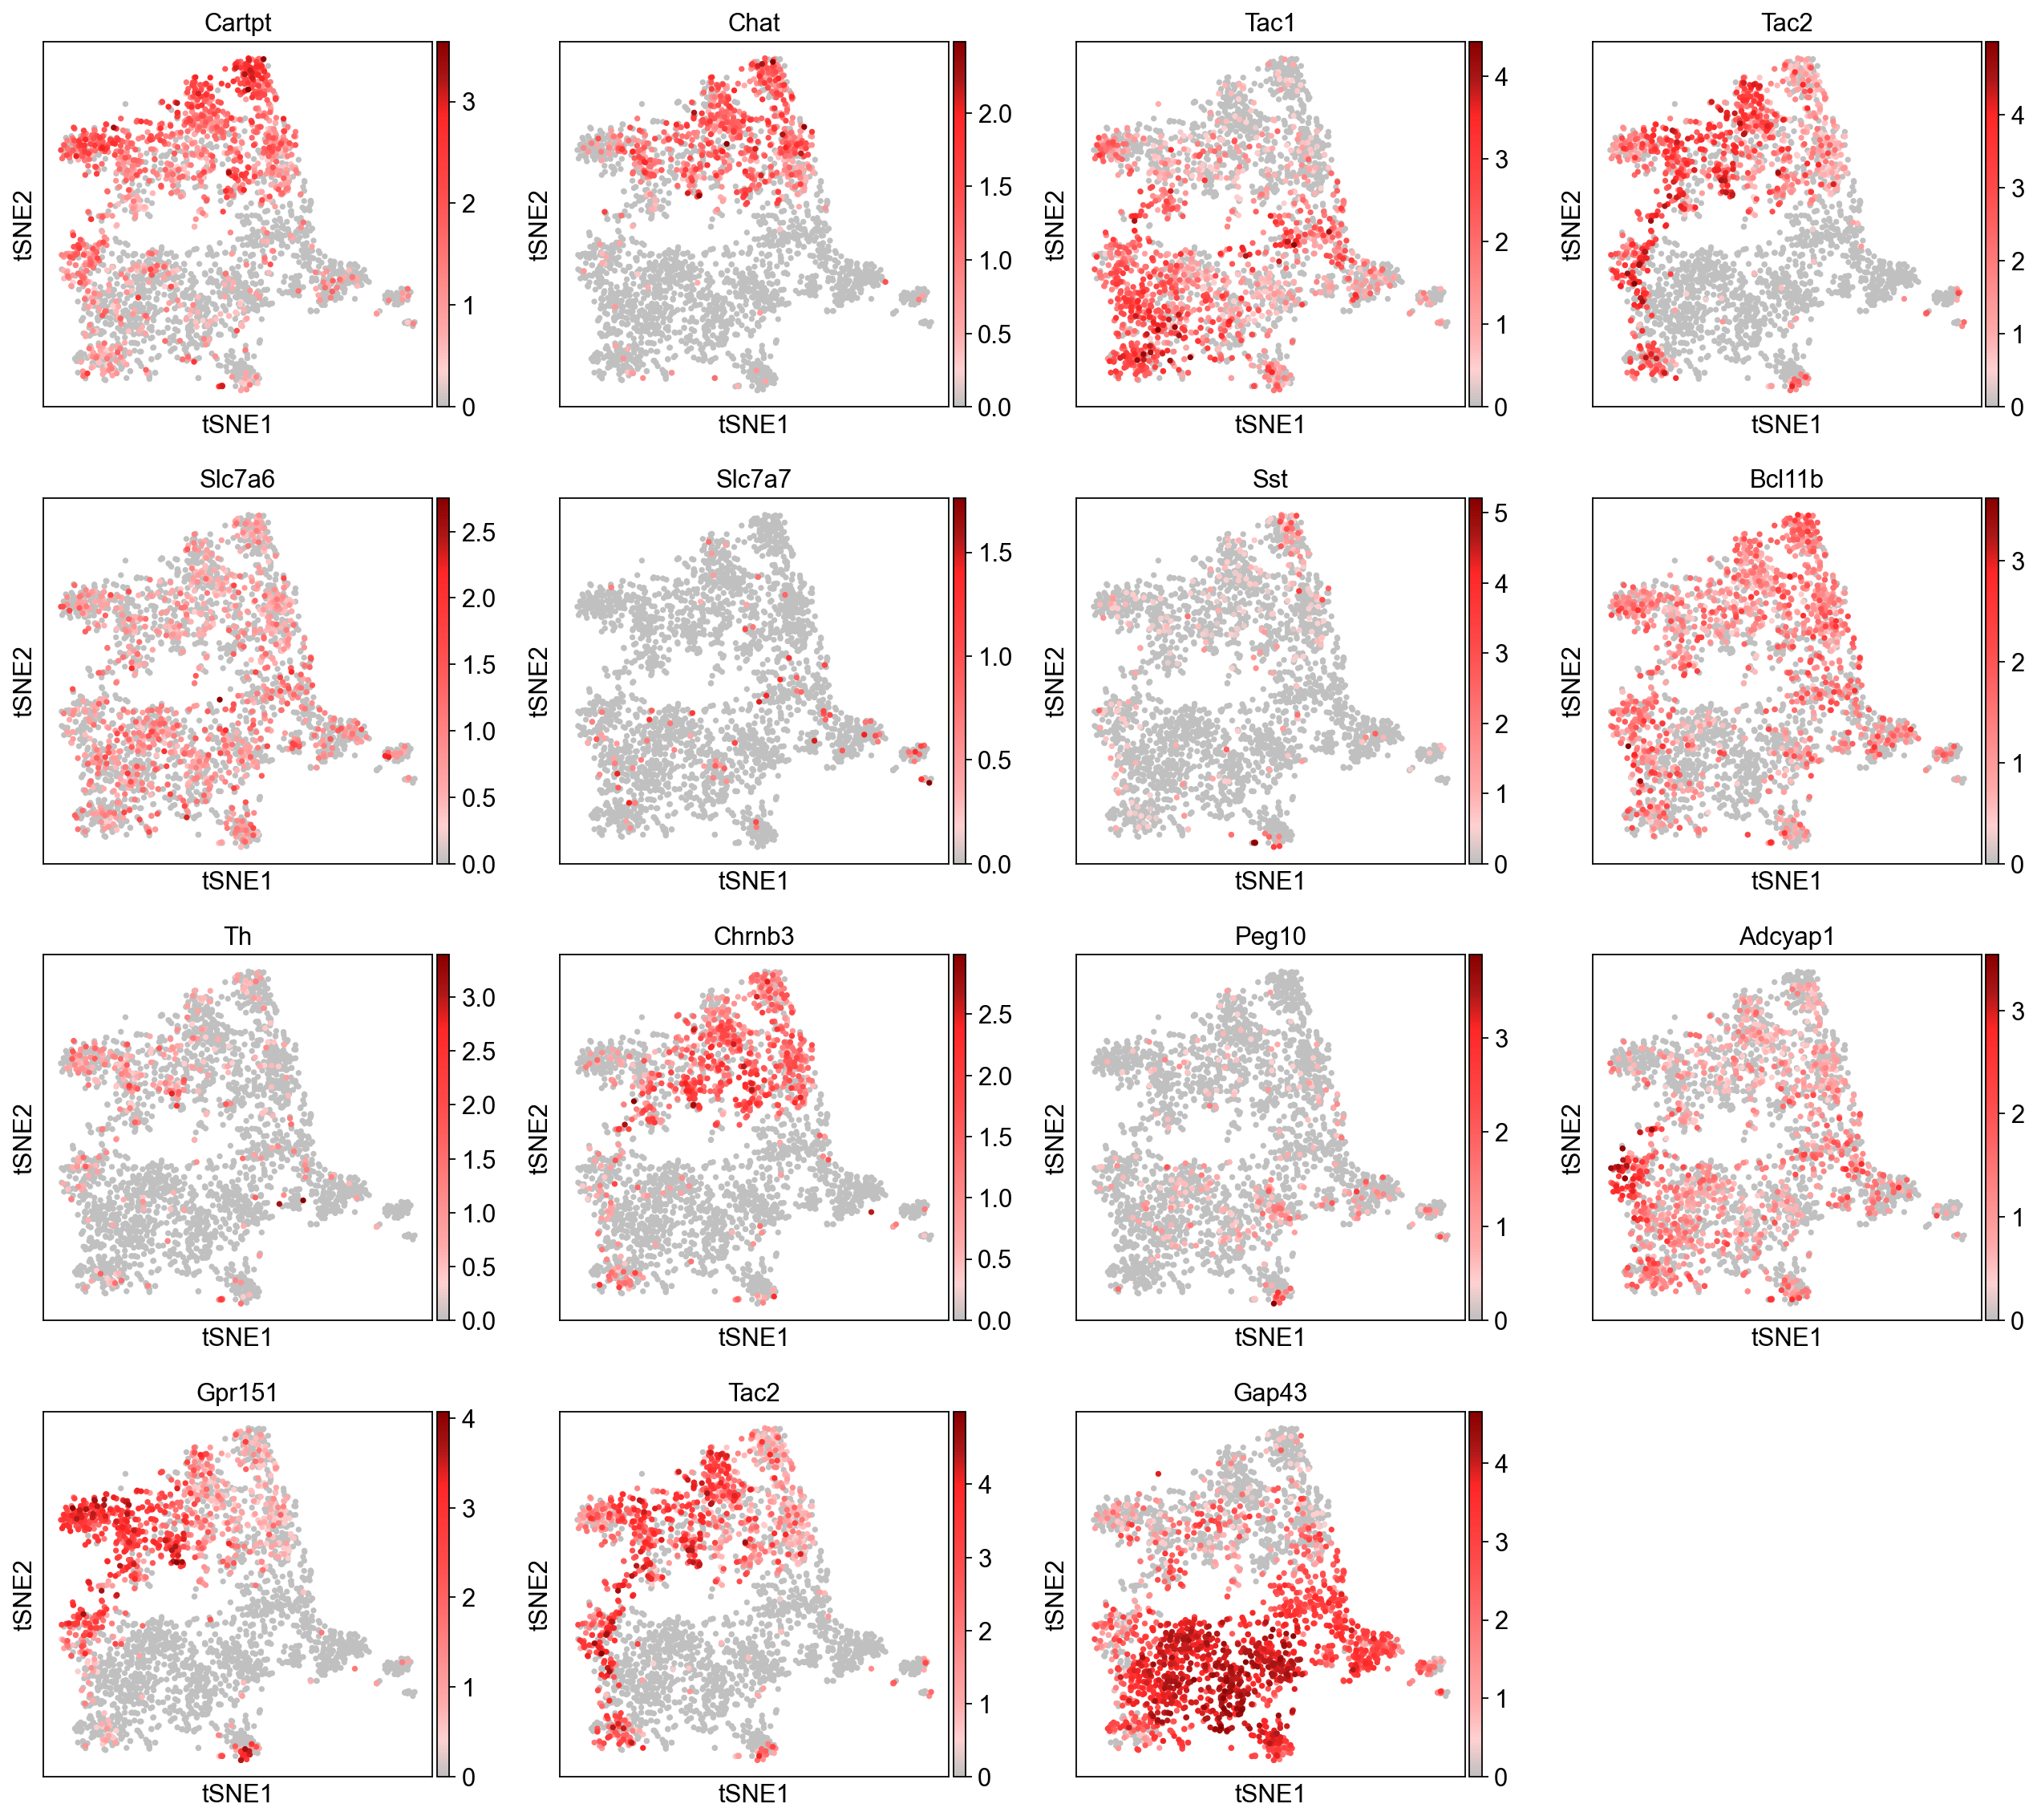

In [10]:
sc.pl.tsne(adata, color= ["Cartpt", 'Chat', 'Tac1', 'Tac2', 'Slc7a6', 'Slc7a7', 'Sst', 'Bcl11b', 'Th', 'Chrnb3', 
                          'Peg10', 'Adcyap1', 'Gpr151', 'Tac2', 'Gap43'], cmap = c_cont_red, save="_Cartpt_neurotransmitters.pdf")